# 📊 Proyecto Final de Estadística (MATCOM, UH) — Curso 2025–2026  
## Análisis Cuantitativo de Mercados Financieros (Acciones vs ETF de Oro)

**Equipo:** _(completar)_  
**Autor/a:** _(completar)_  
**Fecha:** _(completar)_

Este notebook implementa las fases exigidas en la guía del proyecto:  
**3.1** Definición del problema y recopilación de datos · **3.2** EDA · **3.3** Preparación · **3.4** Técnicas estadísticas · **3.5** Conclusiones.

> Guía del proyecto: *Proyecto.pdf*.

## ✅ 0. Preparación del entorno

En este trabajo se emplean bibliotecas estándar de análisis de datos en Python: `numpy`, `pandas`, `matplotlib`, `seaborn`, `scipy` y `scikit-learn`.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    r2_score, mean_squared_error,
    accuracy_score, confusion_matrix, classification_report
)

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)

## 3.1 Definición del Problema y Recopilación de Datos

### 📌 Problema
Los mercados financieros presentan **volatilidad**, **correlaciones** entre activos y **patrones temporales**. A partir de series históricas diarias, podemos aplicar técnicas estadísticas para comparar comportamiento, riesgo y relaciones entre activos.

### ❓ Preguntas de investigación
1. **¿Qué activo presenta mayor volatilidad** en el período analizado?  
2. **¿Existen correlaciones significativas** entre los rendimientos de los activos?  
3. **¿Se pueden identificar grupos (clusters)** de activos según su comportamiento estadístico?  
4. **¿Se puede predecir la dirección diaria** (sube/baja) de un activo usando variables simples?

### 📂 Datos
Se utilizan archivos CSV descargados y adjuntos al proyecto:

- **AAPL** (acción) — Apple Inc.  
- **MSFT** (acción) — Microsoft Corporation  
- **NVDA** (acción) — NVIDIA Corporation  
- **AAAU** (ETF) — Gold ETF respaldado por oro  

**Variables típicas en los CSV:** `Date`, `Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`.

### 3.1.1 Carga de datos

> Si tus CSV están dentro de una carpeta `data/`, cambia `DATA_DIR` a `"data"`.

In [3]:
from pathlib import Path

DATA_DIR = Path("data")  # o Path("data")

files = {
    "AAPL": DATA_DIR / "AAPL.csv",
    "MSFT": DATA_DIR / "MSFT.csv",
    "NVDA": DATA_DIR / "NVDA.csv",
    "AAAU": DATA_DIR / "AAAU.csv",
}

for k, p in files.items():
    if not p.exists():
        raise FileNotFoundError(f"No encuentro {p}. Ajusta DATA_DIR o el nombre del archivo.")

def load_asset(symbol: str, path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Normalizar nombres comunes
    if "Date" not in df.columns:
        raise ValueError(f"{symbol}: no existe columna 'Date'. Columnas: {list(df.columns)}")
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.sort_values("Date").drop_duplicates(subset=["Date"])

    # Algunas fuentes usan 'Adj Close' y otras 'Adj_Close'
    if "Adj Close" not in df.columns and "Adj_Close" in df.columns:
        df = df.rename(columns={"Adj_Close":"Adj Close"})

    # Asegurar que precios/volumen sean numéricos
    for col in ["Open","High","Low","Close","Adj Close","Volume"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")
    return df.reset_index(drop=True)

assets = {sym: load_asset(sym, path) for sym, path in files.items()}
{k: v.head(3) for k, v in assets.items()}

{'AAPL':         Date      Open      High       Low     Close  Adj Close     Volume
 0 1980-12-12  0.513393  0.515625  0.513393  0.513393   0.406782  117258400
 1 1980-12-15  0.488839  0.488839  0.486607  0.486607   0.385558   43971200
 2 1980-12-16  0.453125  0.453125  0.450893  0.450893   0.357260   26432000,
 'MSFT':         Date      Open      High       Low     Close  Adj Close      Volume
 0 1986-03-13  0.088542  0.101562  0.088542  0.097222   0.062378  1031788800
 1 1986-03-14  0.097222  0.102431  0.097222  0.100694   0.064606   308160000
 2 1986-03-17  0.100694  0.103299  0.100694  0.102431   0.065720   133171200,
 'NVDA':         Date      Open      High       Low     Close  Adj Close      Volume
 0 1999-01-22  1.750000  1.953125  1.552083  1.640625   1.509998  67867200.0
 1 1999-01-25  1.770833  1.833333  1.640625  1.812500   1.668188  12762000.0
 2 1999-01-26  1.833333  1.869792  1.645833  1.671875   1.538759   8580000.0,
 'AAAU':         Date   Open   High    Low  Close  Ad

### 3.1.2 Revisión rápida (calidad y rango temporal)

In [4]:
summary = []
for sym, df in assets.items():
    summary.append({
        "Asset": sym,
        "Rows": len(df),
        "Start": df["Date"].min().date(),
        "End": df["Date"].max().date(),
        "Missing_Close": int(df["Close"].isna().sum()) if "Close" in df.columns else None,
        "Missing_AdjClose": int(df["Adj Close"].isna().sum()) if "Adj Close" in df.columns else None,
        "Missing_Volume": int(df["Volume"].isna().sum()) if "Volume" in df.columns else None,
    })
pd.DataFrame(summary)

,Asset,Rows,Start,End,Missing_Close,Missing_AdjClose,Missing_Volume
0,AAPL,9909,1980-12-12,2020-04-01,0,0,0
1,MSFT,8584,1986-03-13,2020-04-01,0,0,0
2,NVDA,5334,1999-01-22,2020-04-01,1,1,1
3,AAAU,410,2018-08-15,2020-04-01,0,0,0


---

## 3.2 Análisis Exploratorio de Datos (EDA)

En finanzas, el análisis se hace típicamente sobre **rendimientos** en lugar de precios. Aquí usaremos:

- Rendimiento simple:  \[
r_t = \frac{P_t - P_{t-1}}{P_{t-1}}
\]
- Rendimiento logarítmico:  \[
\ell_t = \ln(P_t) - \ln(P_{t-1})
\]

Trabajaremos con `Adj Close` si está disponible; en caso contrario, `Close`.

In [5]:
def pick_price_col(df: pd.DataFrame) -> str:
    return "Adj Close" if "Adj Close" in df.columns and df["Adj Close"].notna().any() else "Close"

price_cols = {sym: pick_price_col(df) for sym, df in assets.items()}
price_cols

{'AAPL': 'Adj Close',
 'MSFT': 'Adj Close',
 'NVDA': 'Adj Close',
 'AAAU': 'Adj Close'}

In [ ]:
def add_returns(df: pd.DataFrame, price_col: str) -> pd.DataFrame:
    out = df.copy()
    out["price"] = out[price_col]
    out["ret"] = out["price"].pct_change()
    out["logret"] = out["price"].apply(np.log).diff()
    return out

assets_ret = {sym: add_returns(df, price_cols[sym]) for sym, df in assets.items()}

# Dataset combinado por fecha (rendimientos)
rets = (
    pd.concat(
        [df[["Date","ret","logret"]].assign(Asset=sym) for sym, df in assets_ret.items()],
        ignore_index=True
    )
    .dropna(subset=["ret","logret"])
)

rets.head()

,Date,ret,logret,Asset
1,1980-12-15,-0.052174,-0.053584,AAPL
2,1980-12-16,-0.073395,-0.076227,AAPL
3,1980-12-17,0.024752,0.024451,AAPL
4,1980-12-18,0.028986,0.028574,AAPL
5,1980-12-19,0.061033,0.059243,AAPL


### 3.2.1 Estadísticos descriptivos (rendimientos)

Incluye medidas de tendencia central y dispersión; además curtosis y asimetría para describir colas y sesgo.

In [7]:
desc = (
    rets.groupby("Asset")[["ret","logret"]]
    .agg(["count","mean","std","min","max", stats.skew, stats.kurtosis])
)
desc

ret                                                              logret                                                    \
      count      mean       std       min       max      skew   kurtosis  count      mean       std       min       max      skew   
Asset                                                                                                                               
AAAU    409  0.000778  0.009008 -0.040416  0.056165  0.321660   6.406208    409  0.000737  0.008991 -0.041256  0.054645  0.211186   
AAPL   9908  0.001065  0.028735 -0.518692  0.332278 -0.384935  18.009918   9908  0.000644  0.029188 -0.731247  0.286891 -1.766512   
MSFT   8583  0.001142  0.021532 -0.301159  0.195652 -0.112242  11.037789   8583  0.000909  0.021603 -0.358332  0.178691 -0.598766   
NVDA   5331  0.001723  0.038833 -0.352335  0.424146  0.622322  12.050838   5331  0.000973  0.038688 -0.434382  0.353572 -0.194690   

                  
        kurtosis  
Asset             
AAAU    6.178703  
AAPL   46.692964  
MSFT   15.299536  
NVDA   12.992073

### 3.2.2 Series temporales de precios

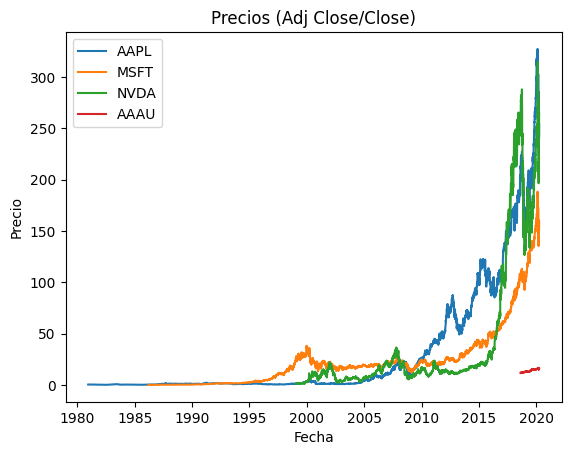

In [8]:
plt.figure()
for sym, df in assets_ret.items():
    plt.plot(df["Date"], df["price"], label=sym)
plt.title("Precios (Adj Close/Close)")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.show()

### 3.2.3 Distribuciones: histogramas y boxplots de rendimientos

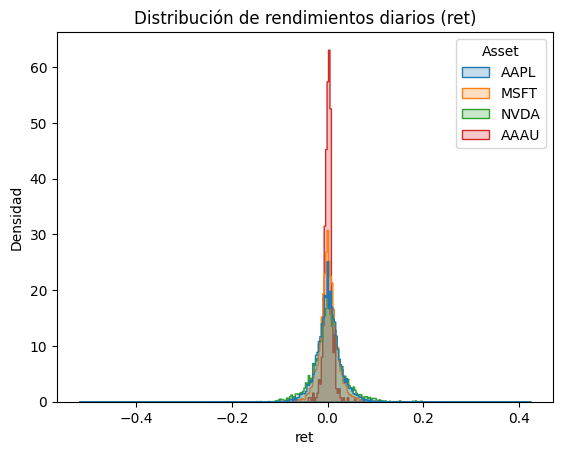

In [9]:
plt.figure()
sns.histplot(data=rets, x="ret", hue="Asset", element="step", stat="density", common_norm=False)
plt.title("Distribución de rendimientos diarios (ret)")
plt.xlabel("ret")
plt.ylabel("Densidad")
plt.show()

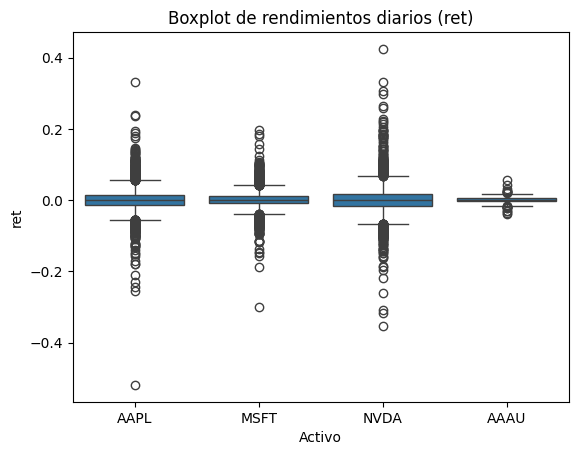

In [10]:
plt.figure()
sns.boxplot(data=rets, x="Asset", y="ret")
plt.title("Boxplot de rendimientos diarios (ret)")
plt.xlabel("Activo")
plt.ylabel("ret")
plt.show()

### 3.2.4 Correlaciones entre activos (sobre rendimientos)

Creamos una tabla por fecha con rendimientos de cada activo y calculamos la matriz de correlación.

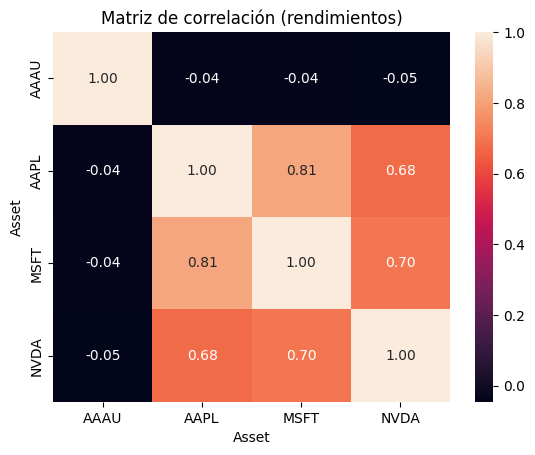

Asset,AAAU,AAPL,MSFT,NVDA
Asset,,,,
AAAU,1.000000,-0.038661,-0.035835,-0.045407
AAPL,-0.038661,1.000000,0.813582,0.676136
MSFT,-0.035835,0.813582,1.000000,0.700779
NVDA,-0.045407,0.676136,0.700779,1.000000


In [11]:
wide = rets.pivot_table(index="Date", columns="Asset", values="ret").dropna()
corr = wide.corr()

plt.figure()
sns.heatmap(corr, annot=True, fmt=".2f")
plt.title("Matriz de correlación (rendimientos)")
plt.show()

corr

---

## 3.3 Preparación de Datos

Acciones típicas:
- Manejo de valores faltantes (por ejemplo, eliminar fechas sin todos los activos).
- Estandarización (necesaria para PCA y K-Means).
- Construcción de variables para clasificación (sube/baja).

### 3.3.1 Dataset final para análisis multivariado

Usaremos fechas donde existan rendimientos para todos los activos (intersección).

In [12]:
X = wide.copy()  # shape: (n_days, n_assets)
X.shape, X.head()

((409, 4),
 Asset           AAAU      AAPL      MSFT      NVDA
 Date                                              
 2018-08-16  0.000000  0.014650 -0.000186 -0.006330
 2018-08-17  0.006814  0.019970 -0.000557 -0.049021
 2018-08-20  0.006768 -0.009743 -0.006600  0.012336
 2018-08-21  0.002521 -0.001949 -0.008328  0.022111
 2018-08-22  0.002515  0.000047  0.010190  0.037502)

### 3.3.2 Estandarización

In [13]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled[:3]

array([[-0.08643419,  0.59558663, -0.06027656, -0.19425497],
       [ 0.67097317,  0.82209064, -0.0771419 , -1.41063123],
       [ 0.6658469 , -0.44301483, -0.35146687,  0.33758328]])

---

## 3.4 Aplicación de Técnicas Estadísticas

La guía pide **al menos 3 técnicas**. Aplicaremos:

1) **Prueba de hipótesis** (comparación de medias de rendimientos: Welch t-test)  
2) **Regresión lineal** (relación entre rendimientos de dos activos)  
3) **PCA** (reducción de dimensionalidad / patrones)  
4) **Clustering** (K-Means en espacio PCA)  
5) **Clasificación** (Regresión logística para predecir sube/baja de un activo)

> Puedes eliminar una si quieres exactamente 3, pero dejar 4–5 técnicas suele mejorar la nota si están bien interpretadas.

### 3.4.1 Pruebas de hipótesis: ¿difieren las medias de rendimientos?

Usaremos **Welch t-test** (no asume varianzas iguales).  
Hipótesis:

- **H0:** la media de rendimientos de A = media de rendimientos de B  
- **H1:** son diferentes  

Nivel de significancia: \(\alpha = 0.05\).

In [14]:
alpha = 0.05
assets_list = list(X.columns)

results_t = []
for i in range(len(assets_list)):
    for j in range(i+1, len(assets_list)):
        a, b = assets_list[i], assets_list[j]
        tstat, pval = stats.ttest_ind(X[a], X[b], equal_var=False, nan_policy="omit")
        results_t.append({
            "A": a, "B": b, 
            "t_stat": float(tstat),
            "p_value": float(pval),
            "Reject_H0_(alpha=0.05)": pval < alpha
        })

pd.DataFrame(results_t).sort_values("p_value")

,A,B,t_stat,p_value,Reject_H0_(alpha=0.05)
5,MSFT,NVDA,0.318991,0.749831,False
1,AAAU,MSFT,-0.309185,0.757300,False
3,AAPL,MSFT,-0.301276,0.763281,False
2,AAAU,NVDA,0.161772,0.871556,False
0,AAAU,AAPL,0.093214,0.925769,False
4,AAPL,NVDA,0.083277,0.933655,False


### 3.4.2 Regresión lineal: ¿explica MSFT los rendimientos de AAPL? (ejemplo)

Modelo:  
\[
r^{AAPL}_t = \beta_0 + \beta_1 r^{MSFT}_t + \varepsilon_t
\]

In [15]:
y = X["AAPL"].values
x = X[["MSFT"]].values

lr = LinearRegression()
lr.fit(x, y)
pred = lr.predict(x)

r2 = r2_score(y, pred)
rmse = mean_squared_error(y, pred, squared=False)

lr.coef_, lr.intercept_, r2, rmse

TypeError: got an unexpected keyword argument 'squared'

In [ ]:
plt.figure()
plt.scatter(X["MSFT"], X["AAPL"], alpha=0.5)
# recta
xs = np.linspace(X["MSFT"].min(), X["MSFT"].max(), 200)
ys = lr.intercept_ + lr.coef_[0]*xs
plt.plot(xs, ys)
plt.title("Regresión lineal: AAPL vs MSFT (rendimientos)")
plt.xlabel("ret MSFT")
plt.ylabel("ret AAPL")
plt.show()

print(f"Modelo: AAPL = {lr.intercept_:.6f} + {lr.coef_[0]:.3f} * MSFT")
print(f"R² = {r2:.3f} | RMSE = {rmse:.5f}")

### 3.4.3 PCA: reducción de dimensionalidad y patrones

Aplicamos PCA sobre rendimientos estandarizados.

In [ ]:
pca = PCA(n_components=min(4, X.shape[1]))
Z = pca.fit_transform(X_scaled)

explained = pca.explained_variance_ratio_
pd.DataFrame({"Componente": [f"PC{i+1}" for i in range(len(explained))],
              "Varianza_Explicada": explained,
              "Varianza_Acumulada": np.cumsum(explained)})

In [ ]:
plt.figure()
plt.plot(np.arange(1, len(explained)+1), np.cumsum(explained), marker="o")
plt.title("Varianza explicada acumulada (PCA)")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza acumulada")
plt.ylim(0, 1.05)
plt.show()

In [ ]:
# Visualización 2D (PC1 vs PC2)
if Z.shape[1] >= 2:
    plt.figure()
    plt.scatter(Z[:,0], Z[:,1], alpha=0.5)
    plt.title("Proyección PCA (PC1 vs PC2) — observaciones diarias")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()

### 3.4.4 Clustering: K-Means en el espacio PCA

Usamos las 2 primeras componentes para agrupar días con comportamiento similar.

In [ ]:
if Z.shape[1] >= 2:
    Z2 = Z[:, :2]
else:
    Z2 = Z

# Elegimos k=3 por simplicidad (puedes explorar con elbow)
k = 3
kmeans = KMeans(n_clusters=k, n_init=20, random_state=42)
labels = kmeans.fit_predict(Z2)

plt.figure()
if Z2.shape[1] >= 2:
    plt.scatter(Z2[:,0], Z2[:,1], c=labels, alpha=0.6)
    plt.title("K-Means sobre PCA (k=3)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
else:
    plt.scatter(np.arange(len(Z2)), Z2[:,0], c=labels, alpha=0.6)
    plt.title("K-Means (1D)")
    plt.xlabel("Índice")
    plt.ylabel("PC1")
plt.show()

pd.Series(labels).value_counts().sort_index()

### 3.4.5 Clasificación: regresión logística para predecir subida/bajada (ejemplo con AAPL)

Definimos variable objetivo:
\[
y_t = \mathbb{1}[r^{AAPL}_t > 0]
\]

Features: rendimientos de los otros activos (MSFT, NVDA, AAAU) del mismo día.
> Nota: esto es una aproximación simple y no necesariamente realista en trading, pero sirve como ejercicio estadístico de clasificación.

In [ ]:
df_cls = X.copy()
df_cls["y_up_AAPL"] = (df_cls["AAPL"] > 0).astype(int)

features = [c for c in df_cls.columns if c not in ["AAPL","y_up_AAPL"]]
Xc = df_cls[features].values
yc = df_cls["y_up_AAPL"].values

X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.25, random_state=42, stratify=yc)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

In [ ]:
print("Accuracy:", acc)
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))
print("\nReporte:\n", classification_report(y_test, y_pred, digits=3))

---

## 3.5 Resultados y Conclusiones

En esta sección debes **responder las preguntas de investigación** con evidencia (tablas, gráficos, p-valores, varianza explicada, etc.).

**Guía para redactar:**
- Volatilidad: compara `std` de rendimientos (EDA).
- Correlaciones: usa la matriz y comenta las más altas/bajas.
- PCA: explica cuánta varianza captura PC1/PC2.
- Clustering: interpreta qué significa agrupar observaciones (días) según comportamiento conjunto.
- Clasificación: reporta métricas y discute limitaciones.

**Limitaciones típicas:**
- Los rendimientos no son perfectamente normales (colas pesadas).
- Cambios estructurales del mercado en el tiempo.
- Modelos simples no capturan no-linealidad.
- Predicción diaria tiene alta incertidumbre.

**Extensiones:**
- Ventanas móviles (volatilidad rolling).
- Modelos ARIMA/GARCH (si estuviese permitido).
- Features retrasadas (lags) para clasificación.

In [ ]:
# Ejemplo de "volatilidad" como desviación estándar de rendimientos
vol = X.std().sort_values(ascending=False)
vol

In [ ]:
plt.figure()
vol.plot(kind="bar")
plt.title("Volatilidad (std de rendimientos diarios)")
plt.xlabel("Activo")
plt.ylabel("Std(ret)")
plt.show()

### 🧾 Conclusión (plantilla)
- El activo con mayor volatilidad en el período analizado fue **(completar)**, evidenciado por **(std más alta / gráfico)**.  
- Se observaron correlaciones **(altas/moderadas/bajas)**, destacando **(pares específicos)**.  
- PCA mostró que **PC1 y PC2** explican aproximadamente **(porcentaje)** de la variabilidad total, lo cual sugiere **(interpretación)**.  
- K-Means identificó **k=3** grupos de observaciones con comportamientos conjuntos diferentes.  
- La regresión logística alcanzó una exactitud de **(accuracy)** para predecir subida/bajada de AAPL, lo cual es **(modesto/aceptable)** dada la dificultad del problema.

*(Completa con tus números reales y discusión.)*